In [3]:
# 目的地の吸着ノードを改札で一つの仮想ノードにするのではなく，改札ごとに分ける
# ホーム→改札に絞る
# 主にmeasuring_model2のところを変える
# gate_node = [33, 36, # 1Fハチ公（d_linkが
#            21, # 3F中央
#            26, 27] # 1F南
# もしやNW作り替える必要がある？？？？

##### 同時推定コード #####
import pandas as pd 
import os
import datetime
import numpy as np
from datetime import timedelta 
import csv
import time
import math
from scipy.stats import norm
from scipy.optimize import minimize

start_time = time.time()
print('start!')

####### reading data #######
df_link_odds = pd.read_csv("/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link_corrected/shibuya_link_pre_odds.csv")
l = len(df_link_odds)

df_link_integrated = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link_corrected/shibuya_link_pre_integrated.csv')
L = len(df_link_integrated)

search_folder = "/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/quater_address750"
file_list = list(os.listdir(search_folder))

df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_node.csv')
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

###### 各linkのoとdの座標を入れておく配列 ######
oddslink_loc_array = [] # 空リストを用意
for i in range(len(df_link_odds)):
    linkid = df_link_odds.loc[i, 'linkid']
    O = df_link_odds.loc[i, 'O']
    D = df_link_odds.loc[i, 'D']

    x_o = df_node[df_node['nodeid'] == O]['x'].iloc[0]
    y_o = df_node[df_node['nodeid'] == O]['y'].iloc[0]
    z_o = df_node[df_node['nodeid'] == O]['floor'].iloc[0] * 1000
    o_loc = np.array([x_o, y_o, z_o])

    x_d = df_node[df_node['nodeid'] == D]['x'].iloc[0]
    y_d = df_node[df_node['nodeid'] == D]['y'].iloc[0]
    z_d = df_node[df_node['nodeid'] == D]['floor'].iloc[0] * 1000 # これでseriesではなく値として抽出できるはず
    d_loc = np.array([x_d, y_d, z_d])

    loc_tuple = (o_loc, d_loc)

    oddslink_loc_array.append(loc_tuple) # oddslink_loc_array[linkid//2][0]がlinkidのonode, [1]がdnode，[2]が中点，，，，

###### ビーコンとリンク線分の最短距離返す関数 ######
def shortest_distance_to_segment(p1, p2, x):
    p1 = np.array(p1)
    p2 = np.array(p2)
    x = np.array(x)
    
    segment = p2 - p1
    v1 = x - p1
    v2 = x - p2
    
    # 垂直ベクトルを計算
    v = v1 - np.dot(v1, segment) / np.dot(segment, segment) * segment
    
    # 垂直ベクトルのノルム（距離）を求める
    distance = np.linalg.norm(v)
    
    # 線分の範囲内であるかチェック
    dot_product = np.dot(v1, segment)
    if dot_product < 0:
        return np.linalg.norm(x - p1)
    elif dot_product > np.dot(segment, segment):
        return np.linalg.norm(x - p2)
    else:
        return distance

###### d_arrayの用意 ###### # 各リンク(奇数側)とbleビーコンとの距離配列
d_array = np.zeros((len(df_link_odds), len(df_ble)))

for i in range(len(df_link_odds)):
    p_o = oddslink_loc_array[i][0] # o座標 # i=1の時
    p_d = oddslink_loc_array[i][1] # d座標

    for j in range(len(df_ble)):
        x_ap = df_ble.loc[j, 'x']
        y_ap = df_ble.loc[j, 'y']
        z_ap = df_ble.loc[j, 'floor']*1000 # zの値をめちゃ大きくすることで，階を挟んだ電波捕捉を捨象（階の厳密な高さが不明なのと，床板・天井版による電波遮蔽を考慮するため）．階が同じなら0になるので変な影響はない
        p_ap = np.array([x_ap, y_ap, z_ap])

        d_array[i, j] = shortest_distance_to_segment(p_o, p_d, p_ap)


start!


In [4]:
print(d_array)

[[1.93317121e+01 1.99565353e+01 2.59417688e+01 ... 5.70186411e+03
  6.53518638e+00 5.02102614e+01]
 [5.17203261e+01 1.92698605e+01 1.91518517e+01 ... 5.70147863e+03
  8.09632040e-02 3.42526859e+01]
 [6.67702566e+01 2.20745446e+01 1.91381366e+01 ... 5.70068596e+03
  9.42401114e+00 2.00060568e+00]
 ...
 [5.87047827e+01 1.69816198e+01 1.91484260e+01 ... 5.70173603e+03
  3.59026820e+01 5.48073701e+01]
 [8.37752006e+01 3.26823111e+01 2.22350045e+01 ... 5.70114965e+03
  4.35071786e+01 3.62403719e+01]
 [1.73723256e+02 1.20639098e+02 1.08255861e+02 ... 1.65817242e+01
  1.20707128e+02 7.77545749e+01]]


In [5]:
# 各リンクから半径xm圏内にあるビーコンの数
counts = [sum(1 for value in row if value <= 20) for row in d_array]
print(counts)

[3, 3, 4, 2, 2, 5, 3, 7, 4, 1, 2, 4, 3, 4, 4, 4, 4, 5, 2, 2, 1, 2, 1, 3, 3, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 3, 2, 3, 2, 1, 2, 2, 6, 8, 2, 1, 3, 6, 2, 3]


In [6]:
# 各リンクから半径xm圏内にあるビーコンの数
counts = [sum(1 for value in row if value <= 15) for row in d_array]
print(counts)

[1, 1, 2, 1, 1, 2, 2, 5, 2, 1, 2, 1, 1, 4, 2, 3, 2, 3, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 3, 1, 0, 1, 2, 1, 1]


In [7]:
# 各リンクから半径xm圏内にあるビーコンの数
counts = [sum(1 for value in row if value <= 14) for row in d_array]
print(counts)

[1, 1, 2, 1, 1, 2, 2, 3, 2, 1, 2, 1, 1, 4, 2, 3, 2, 3, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1]


In [53]:
# 各リンクから半径xm圏内にあるビーコンの数（0のリンクは観測されないことになる．数字の数だけ，ダブルで観測される可能性がある）
counts = [sum(1 for value in col if value <= 10) for col in d_array]
print(counts)

[1, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1]


In [54]:
transposed_array = [[d_array[j][i] for j in range(len(d_array))] for i in range(len(d_array[0]))]

# 各beaconから半径10m圏内にあるリンク数をカウント
counts = [sum(1 for value in col if value <= 10) for col in transposed_array]
print(counts)
print(len(counts))
# postの時0になっているのは山手線外回りホーム（廃止）か3F中央改札に設置しているビーコンなので無問題
# 値は，各ビーコンの観測に対して観測確率が割り当てられるリンクの数を示す．少ない方がいい（それはそう）

[3, 2, 4, 1, 3, 2, 5, 1, 4, 1, 2, 2, 2, 5, 3, 3, 1, 1, 3, 3, 2, 5, 4]
23


In [46]:
# 各beaconから半径15m圏内にあるリンク数をカウント
counts = [sum(1 for value in col if value <= 15) for col in transposed_array]
print(counts)
print(len(counts))

[3, 3, 3, 1, 2, 4, 4, 0, 0, 1, 0, 0, 0, 1, 3, 2, 1, 1, 4, 4, 2, 5, 4]
23


In [47]:
# 各beaconから半径20m圏内にあるリンク数をカウント
counts = [sum(1 for value in col if value <= 20) for col in transposed_array]
print(counts)
print(len(counts))

[4, 8, 8, 3, 2, 5, 5, 3, 3, 2, 0, 0, 0, 1, 4, 2, 1, 3, 4, 6, 5, 5, 5]
23


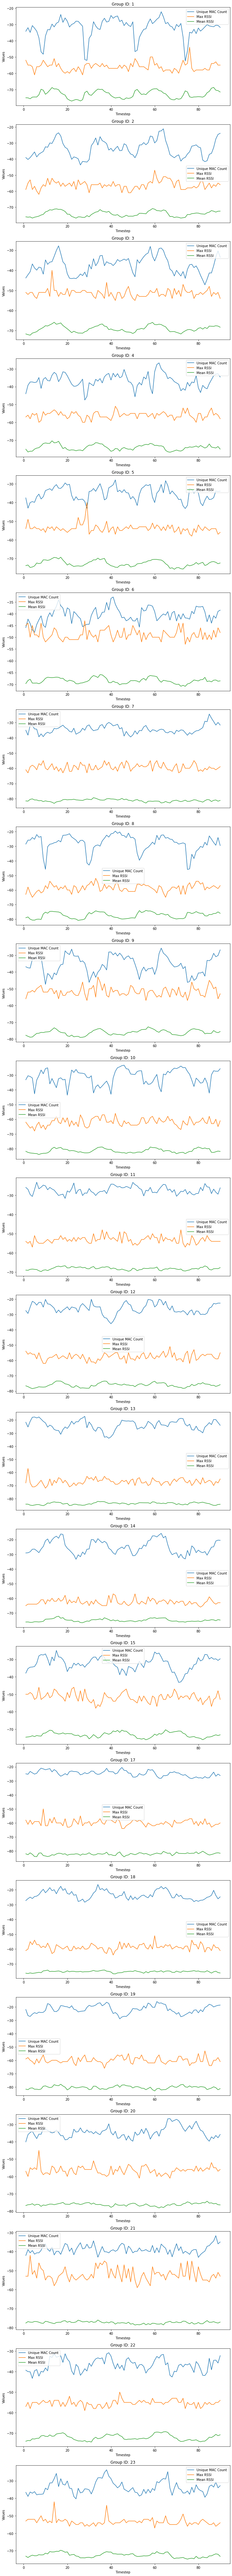

In [57]:
# 10秒ごとで各ビーコンでの最大RSSIと混雑率の相関を見たい
import pandas as pd 
import matplotlib.pyplot as plt 
df = pd.read_csv('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20221218_17/20221218_1715.csv')

# print(df_quater.dtypes) 最初timeはobjectなのでdatetime形式に変換
df['time'] = pd.to_datetime(df['time'])

# timeの昇順でデータを並べ替え
df = df.sort_values('time', ascending=True).reset_index(drop=True)

# time_stepを10秒間隔で付与
time_delta = pd.Timedelta(seconds=10)
df['timestep'] = (df['time'] - df['time'].iloc[0]) // time_delta + 1

# beaconごとにグルーピングして，混雑の様子と最大の観測強度の算定
grouped = df.groupby('ID')


# 各グループ内，各timestepで，グラフの可視化をしたい
x = [i for i in range(1, 91)]
"""
y1 = df['MAC'].nunique()
y2 = df['RSSI'].max()
y3 = mean(df['RSSI'])
"""
# こいうの書けるようにしないとだよ？？
# Create a figure and axis for subplots
fig, axs = plt.subplots(len(grouped), 1, figsize=(10, len(grouped)*5))

# Iterate over each group
for i, (group_name, group_df) in enumerate(grouped):
    # Calculate the mean, max, and unique count for each timestep
    y1 = group_df.groupby('timestep')['MAC'].nunique()/(-10)
    y2 = group_df.groupby('timestep')['RSSI'].max()
    y3 = group_df.groupby('timestep')['RSSI'].mean()

    # Plot the graphs for each group
    axs[i].plot(x, y1, label='Unique MAC Count')
    axs[i].plot(x, y2, label='Max RSSI')
    axs[i].plot(x, y3, label='Mean RSSI')
    
    axs[i].set_title(f'Group ID: {group_name}')
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel('Values')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

# Assuming 'timestep' is a column in your DataFrame
x = [i for i in range(1, 91)]

# Create a DataFrame for each group's aggregated values
aggregated_data = pd.DataFrame()
aggregated_data['Unique MAC Count'] = grouped.apply(lambda group: group.groupby('timestep')['MAC'].nunique() / (-10)).stack()
aggregated_data['Max RSSI'] = grouped.apply(lambda group: group.groupby('timestep')['RSSI'].max()).stack()
aggregated_data['Mean RSSI'] = grouped.apply(lambda group: group.groupby('timestep')['RSSI'].mean()).stack()

# Create a scatter matrix
sns.set(style="ticks")
sns.pairplot(aggregated_data, diag_kind='kde', markers='o', height=2)
plt.show()

In [1]:
for i in range(10):
    for j in range(8):
        if j == 2:
            continue
        if j == 5:
            print("Breaked!")
            break
        
        print((i, j))

(0, 0)
(0, 1)
(0, 3)
(0, 4)
Breaked!
(1, 0)
(1, 1)
(1, 3)
(1, 4)
Breaked!
(2, 0)
(2, 1)
(2, 3)
(2, 4)
Breaked!
(3, 0)
(3, 1)
(3, 3)
(3, 4)
Breaked!
(4, 0)
(4, 1)
(4, 3)
(4, 4)
Breaked!
(5, 0)
(5, 1)
(5, 3)
(5, 4)
Breaked!
(6, 0)
(6, 1)
(6, 3)
(6, 4)
Breaked!
(7, 0)
(7, 1)
(7, 3)
(7, 4)
Breaked!
(8, 0)
(8, 1)
(8, 3)
(8, 4)
Breaked!
(9, 0)
(9, 1)
(9, 3)
(9, 4)
Breaked!
